In [482]:
import cv2
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


def read_image(path: str):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def down_to_64(x):
    return F.interpolate(x, (64, 64), mode="area")


def up_to_256(x):
    return F.interpolate(x, (256, 256), mode="bilinear")

def mask_to_box(mask):
    mask = mask[0, 0] > 0
    mask = mask.detach().cpu().numpy()
    mask_pts = np.argwhere(mask)
    min_y = np.min(mask_pts[:, 0])
    min_x = np.min(mask_pts[:, 1])
    max_y = np.max(mask_pts[:, 0])
    max_x = np.max(mask_pts[:, 1])
    next_box = np.array([min_x, min_y, max_x, max_y])
    return next_box

class SamTracker:
    
    def __init__(self, checkpoint):
        model_type = "vit_t"
        sam_checkpoint = checkpoint
        device = "cuda" if torch.cuda.is_available() else "cpu"
        mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        mobile_sam.to(device=device)
        mobile_sam.eval()
        self.predictor = SamPredictor(mobile_sam)

    def compute_features(self, image):
        self.predictor.set_image(image)
        return self.predictor.features
        
    def compute_features_and_mask(self, image, bbox):
        self.predictor.set_image(image)
        _, _, mask = self.predictor.predict(
            box=bbox,
            multimask_output=False
        )
        return self.predictor.features, torch.from_numpy(mask[None, ...]).cuda()

    def refine_mask(self, image, bbox, mask, scale=50., iters=2, set_image=True):
        if set_image:
            self.predictor.set_image(image)
        mask = scale * mask[0] # remove batch dim
        for i in range(iters):
            _, _, mask = self.predictor.predict(
                box=bbox,
                multimask_output=False,
                mask_input=mask
            )
            mask = mask * scale
        return torch.from_numpy(mask[None, ...]).cuda() # add batch dim

    def fit_lstsq_mask_token(self, features, mask):
        """
        Finds token that when dot-producted with features minimizes MSE with low 
        resolution masks.

        Args:
            features (Nx256x64x64)
            mask (Nx1x64x64) - Should be logits type
        """
        with torch.no_grad():
            N = features.shape[0]
            assert N == mask.shape[0]
            A = features.permute(0, 2, 3, 1).reshape(N * 64 * 64, 256)
            B = mask.permute(0, 2, 3, 1).reshape(N * 64 * 64, 1)
            X = torch.linalg.lstsq(A, B).solution.reshape(1, 256, 1, 1)
        return X.detach()
    
    def apply_token(self, features, token):
        return up_to_256(torch.sum(features * token, dim=(1), keepdim=True))

    def init(self, image, bbox):
        scale = max(image.shape[0], image.shape[1]) / 256.
        features, mask = self.compute_features_and_mask(image, bbox)
        token = self.fit_lstsq_mask_token(features, down_to_64(mask))
        self.token = token
        mask_token = self.apply_token(features, token)
        mask_bbox = mask_to_box(mask_token) * scale
        mask_token_refined = self.refine_mask(image, mask_bbox, mask_token, scale=1, set_image=False)
        return mask_bbox, mask_token_refined

    def update(self, image):
        if not hasattr(self, 'token'):
            raise RuntimeError("No token found.  Did you call tracker.init()?")
        scale = max(image.shape[0], image.shape[1]) / 256.
        features = self.compute_features(image)
        mask_token = self.apply_token(features, self.token)
        mask_bbox = mask_to_box(mask_token) * scale
        mask_token_refined = self.refine_mask(image, mask_bbox, mask_token, scale=1, iters=1)
        self.token = self.fit_lstsq_mask_token(features, down_to_64(mask_token_refined))
        return mask_bbox, mask_token_refined

In [483]:
tracker = SamTracker("../weights/mobile_sam.pt")

In [484]:
bbox, mask = tracker.init(read_image("../data/images_track_1/frame_0.jpg"), np.array([420, 100, 620, 400]))

In [ ]:
video_writer = cv2.VideoWriter('../data/person.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 20, (640, 480))

In [496]:
mask.shape

torch.Size([1, 1, 256, 256])

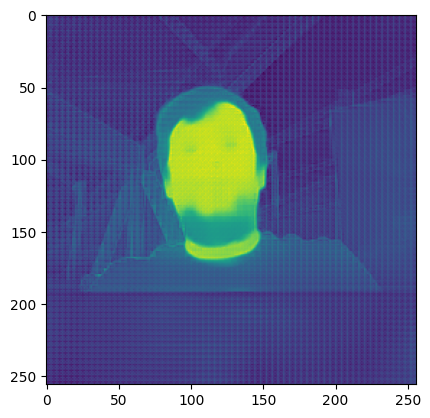

In [495]:
bbox, mask = tracker.update(read_image("../data/images_track_1/frame_90.jpg"))
plt.imshow(mask[0,0].detach().cpu())
plt.show()

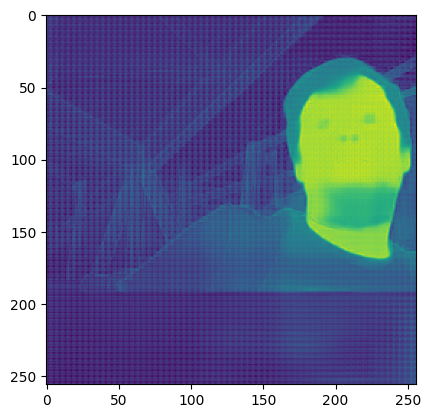

In [485]:
plt.imshow(mask[0,0].detach().cpu())
plt.show()

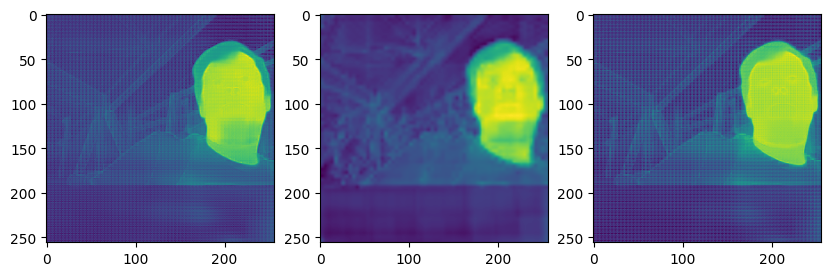

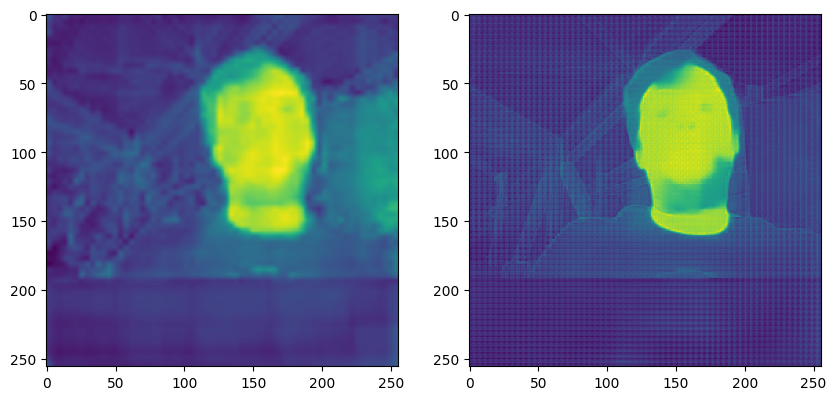

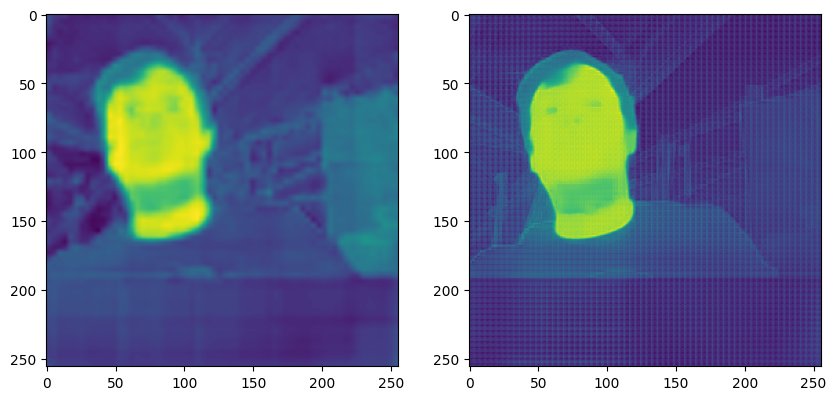

In [468]:
image = read_image("../data/images_track_1/frame_0.jpg")
bbox = np.array([420, 100, 620, 400])
features, mask = tracker.compute_features_and_mask(image, bbox)
token = tracker.fit_lstsq_mask_token(features, down_to_64(mask))
mask_token = tracker.apply_token(features, token)
mask_bbox = mask_to_box(mask_token)
mask_token_refined = tracker.refine_mask(image, bbox, mask_token, scale=1)
features_0 = features
mask_0 = mask

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(mask[0, 0].detach().cpu())
plt.subplot(132)
plt.imshow(mask_token[0, 0].detach().cpu())
plt.subplot(133)
plt.imshow(mask_token_refined[0, 0].detach().cpu())
plt.show()

image = read_image("../data/images_track_1/frame_10.jpg")
features = tracker.compute_features(image)
mask_token = tracker.apply_token(features, token)
mask_bbox = mask_to_box(mask_token) * 640/256
# _, mask_token_refined = tracker.compute_features_and_mask(image, mask_bbox)
mask_token_refined = tracker.refine_mask(image, mask_bbox, mask_token, scale=1, iters=1)
features_1 = features
mask_1 = mask_token_refined

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(mask_token[0, 0].detach().cpu())
plt.subplot(122)
plt.imshow(mask_token_refined[0, 0].detach().cpu())
plt.show()

token = tracker.fit_lstsq_mask_token(torch.cat([features_1], dim=0), down_to_64(torch.cat([mask_1], dim=0)))
image = read_image("../data/images_track_1/frame_20.jpg")
features = tracker.compute_features(image)
mask_token = tracker.apply_token(features, token)
mask_bbox = mask_to_box(mask_token) * 640/256
# _, mask_token_refined = tracker.compute_features_and_mask(image, mask_bbox)
mask_token_refined = tracker.refine_mask(image, mask_bbox, mask_token, scale=1, iters=1)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(mask_token[0, 0].detach().cpu())
plt.subplot(122)
plt.imshow(mask_token_refined[0, 0].detach().cpu())
plt.show()

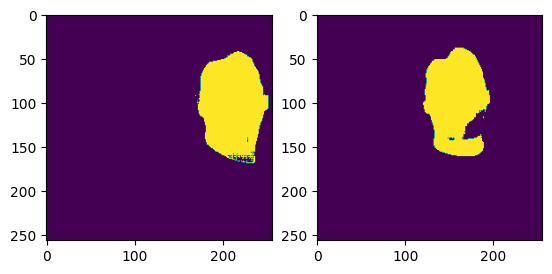

In [459]:
plt.subplot(121)
plt.imshow(mask_0[0,0].detach().cpu() > 0)
plt.subplot(122)
plt.imshow(mask_1[0,0].detach().cpu() > 0)

In [407]:
token.shape

torch.Size([1, 256, 1, 1])

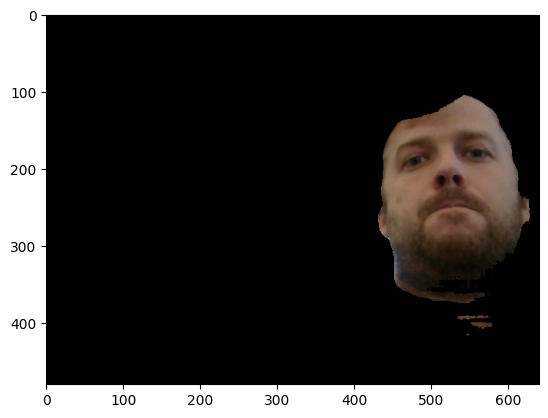

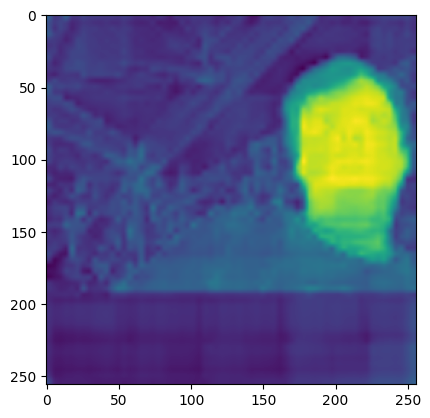

In [376]:
imgvis = np.copy(image)
imgvis[mask[0] == 0] = 0
plt.imshow(imgvis)
# plt.imshow(mask[0], alpha=0.5)
plt.show()
plt.imshow(low_mask[0].detach().cpu())
plt.show()

In [194]:
iou_preds

array([0.88793856, 0.8964559 , 0.8606359 ], dtype=float32)

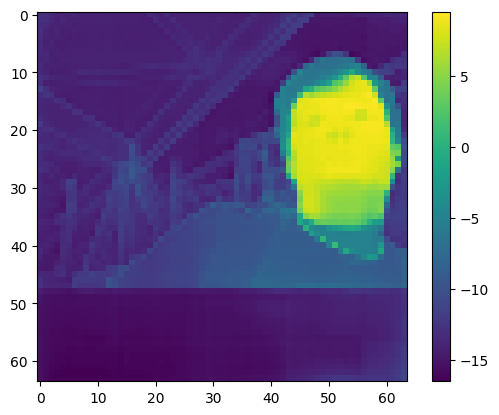

In [258]:
import torch.nn.functional as F
low_mask_torch = torch.from_numpy(new_low_mask[0]).cuda().float()
# low_mask_torch = torch.sigmoid(low_mask_torch)
low_mask_torch = F.interpolate(low_mask_torch[None, None, ...], size=(64, 64), mode='area')
plt.imshow(low_mask_torch[0, 0].detach().cpu())
plt.colorbar()
plt.show()

In [280]:
A = predictor.features.reshape(256, 64*64).permute(1, 0)
B = low_mask_torch.reshape((64*64, 1))
X = torch.linalg.lstsq(A, B).solution.reshape(1, 256, 1, 1)

In [281]:
import time

In [282]:

torch.cuda.current_stream().synchronize()
t0 = time.monotonic()
for i in range(1):
    X = torch.linalg.lstsq(A, B).solution.reshape(1, 256, 1, 1)

torch.cuda.current_stream().synchronize()
t1 = time.monotonic()
print((100) / (t1- t0))

4480.637194650335


In [271]:
image = cv2.imread("../data/images_track_1/frame_10.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

In [132]:

out = torch.sum(proj_feature * predictor.features, dim=(1,), keepdim=True)

In [283]:

out = torch.sum(X * predictor.features, dim=(1,), keepdim=True)

In [284]:
out.shape

torch.Size([1, 1, 64, 64])

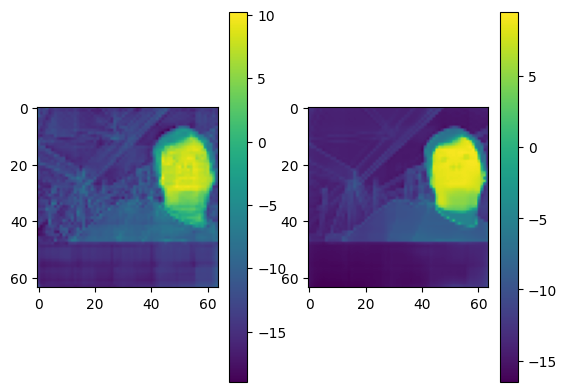

In [285]:
plt.subplot(121)
plt.imshow(out[0,0].detach().cpu())
plt.colorbar()
plt.subplot(122)
plt.imshow(low_mask_torch[0,0].detach().cpu())
plt.colorbar()
plt.show()